In [33]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.control import ConstControl
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
from pandapower import ppException

import matplotlib.pyplot as plt
from scipy.stats import norm


In [34]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Power Network 

In [35]:
# Create PandaPower network (30bus) /(300bus)
# net = pn.case30() #30 Bus Dynamic Test Case

#The IEEE 300-bus system contains 69 generators, 60 LTCs, 304 transmission lines, and 195 loads.
net = pn.case300()

# View all generator (gen) information and Slack bus
gen_info = net.gen
print(gen_info)
print(net.ext_grid)

# Identify PV buses (buses with generators) in the IEEE 300-bus system
pv_buses = net.gen['bus'].tolist()

print("PV Buses in IEEE 300-bus system:", pv_buses)

    name  bus     p_mw   vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  \
0   None    7     0.00  1.0153     NaN      -10.00       10.00      1.0   
1   None    9     0.00  1.0205     NaN      -20.00       20.00      1.0   
2   None   18     0.00  1.0010     NaN      -20.00       20.00      1.0   
3   None   54     0.00  0.9583     NaN      -25.00       25.00      1.0   
4   None   62     0.00  0.9632     NaN       12.00       35.00      1.0   
5   None   68   375.00  1.0250     NaN     -240.00      240.00      1.0   
6   None   75   155.00  1.0520     NaN      -11.00       96.00      1.0   
7   None   76   290.00  1.0520     NaN     -153.00      153.00      1.0   
8   None   79    68.00  1.0000     NaN      -30.00       56.00      1.0   
9   None   87   117.00  0.9900     NaN      -24.00       77.00      1.0   
10  None   97  1930.00  1.0435     NaN     -500.00     1500.00      1.0   
11  None  102   240.00  1.0233     NaN      -60.00      120.00      1.0   
12  None  103     0.00  1

In [36]:
# View the bus information of the external power grid (Slack bus)
slack_bus_numbers = net.ext_grid['bus'].values
print("Slack bus numbers:", slack_bus_numbers)

# View load information
print(net.load)

# Calculate total active power and reactive power
total_p = net.load['p_mw'].sum()  # Total active power
total_q = net.load['q_mvar'].sum()  # Total reactive power

print(f"Total active power load of IEEE 300-bus system: {total_p} MW")
print(f"Total reactive power load of IEEE 300-bus system: {total_q} MVar")

Slack bus numbers: [256]
     name  bus     p_mw  q_mvar  const_z_percent  const_i_percent  sn_mva  \
0    None    0    90.00   49.00              0.0              0.0     NaN   
1    None    1    56.00   15.00              0.0              0.0     NaN   
2    None    2    20.00    0.00              0.0              0.0     NaN   
3    None    4   353.00  130.00              0.0              0.0     NaN   
4    None    5   120.00   41.00              0.0              0.0     NaN   
5    None    7    63.00   14.00              0.0              0.0     NaN   
6    None    8    96.00   43.00              0.0              0.0     NaN   
7    None    9   153.00   33.00              0.0              0.0     NaN   
8    None   10    83.00   21.00              0.0              0.0     NaN   
9    None   12    58.00   10.00              0.0              0.0     NaN   
10   None   13   160.00   60.00              0.0              0.0     NaN   
11   None   14   126.70   23.00              0.0   

In [37]:
# Initialize an empty list to store the installed capacities of each generator
installed_capacities = []

# Loop through each row in the gen_info DataFrame to extract information
for i, row in gen_info.iterrows():
    bus_id = row['bus']  # Get the bus ID for the generator
    installed_capacity = row['max_p_mw']  # Get the installed capacity of the generator in MW
    print(f"Generator at Bus {bus_id}: Installed Capacity = {installed_capacity} MW")
    installed_capacities.append(installed_capacity)  # Append the capacity to the list

# Calculate the total installed capacity of all generators
total_installed_capacity = sum(installed_capacities)
print(f"Total Installed Capacity = {total_installed_capacity} MW")

# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")
    
#Remove any extra sgen outside the PV buses.
for bus in net.sgen['bus'].values:
    if bus not in pv_buses:
        net.sgen.drop(net.sgen[net.sgen['bus'] == bus].index, inplace=True)

# View all sgen information
sgen_info = net.sgen
print(sgen_info)

Generator at Bus 7: Installed Capacity = 100.0 MW
Generator at Bus 9: Installed Capacity = 100.0 MW
Generator at Bus 18: Installed Capacity = 100.0 MW
Generator at Bus 54: Installed Capacity = 100.0 MW
Generator at Bus 62: Installed Capacity = 100.0 MW
Generator at Bus 68: Installed Capacity = 475.0 MW
Generator at Bus 75: Installed Capacity = 255.0 MW
Generator at Bus 76: Installed Capacity = 390.0 MW
Generator at Bus 79: Installed Capacity = 168.0 MW
Generator at Bus 87: Installed Capacity = 217.0 MW
Generator at Bus 97: Installed Capacity = 2030.0 MW
Generator at Bus 102: Installed Capacity = 340.0 MW
Generator at Bus 103: Installed Capacity = 100.0 MW
Generator at Bus 116: Installed Capacity = 100.0 MW
Generator at Bus 119: Installed Capacity = 381.0 MW
Generator at Bus 121: Installed Capacity = 796.0 MW
Generator at Bus 124: Installed Capacity = 184.0 MW
Generator at Bus 125: Installed Capacity = 317.0 MW
Generator at Bus 127: Installed Capacity = 203.0 MW
Generator at Bus 130: In

## Load data and Data processing

In [38]:
# Load the CSV file with the ERCOT time-series data file
# file_path = 'C:\\Users\\default.DESKTOP-C4C7JDR\\Desktop\\ERCOT SOLAR DATA.xlsx'  # Home PC
file_path = 'C:\\Users\\jliu359\\OneDrive - Syracuse University\\Desktop\\ERCOT SOLAR DATA.xlsx' #Lab PC
ercot_data = pd.read_excel(file_path)
# Read data
print(ercot_data.head())

# Extract the time and PV generation columns
# Set the time column as the index and ensure it's in DateTime format
ercot_data['Time (Hour-Ending)'] = pd.to_datetime(ercot_data['Time (Hour-Ending)'])
ercot_data.set_index('Time (Hour-Ending)', inplace=True)
pv_generation = ercot_data['ERCOT.PVGR.GEN']

# Scale ERCOT's generation to match the total installed capacity of the PV buses
scaling_factor = total_installed_capacity / 14249  # 14249 MW is the total solar installed capacity in the ERCOT dataset
scaled_pv_generation = pv_generation * scaling_factor

# Prepare a DataFrame to hold profiles for each PV bus with an integer index
profiles_df = pd.DataFrame(index=range(len(ercot_data)))

   Time (Hour-Ending)       Date    ERCOT.LOAD  ERCOT.PVGR.GEN  \
0 2023-01-01 01:00:00 2023-01-01  35829.306163        0.449746   
1 2023-01-01 02:00:00 2023-01-01  35245.390234        0.454733   
2 2023-01-01 03:00:00 2023-01-01  34599.761810        0.443528   
3 2023-01-01 04:00:00 2023-01-01  34227.151061        0.458567   
4 2023-01-01 05:00:00 2023-01-01  34093.414143        0.451126   

   Total Solar Installed, MW  Solar Output, % of Load  \
0                      14249                 0.001255   
1                      14249                 0.001290   
2                      14249                 0.001282   
3                      14249                 0.001340   
4                      14249                 0.001323   

   Solar Output, % of Installed  Solar 1-hr MW change  Solar 1-hr % change  \
0                      0.003156                   NaN                  NaN   
1                      0.003191                   0.0                  0.0   
2                      0.0

In [41]:
# Assign the scaled generation to the PV buses as injected photovoltaic output based on their capacities
for i, bus in enumerate(pv_buses):
    # Calculate the proportion of generation for each PV bus
    bus_scaling_factor = installed_capacities[i] / total_installed_capacity
    bus_generation_profile = scaled_pv_generation * bus_scaling_factor

    # Add the generation profile to the DataFrame with a consistent column name
    column_name = f'bus_{bus}_p_mw'
    profiles_df[column_name] = bus_generation_profile.values

    # Create a DFData object with the profiles DataFrame
    data_source = DFData(profiles_df)

    # Create ConstControl objects for each PV bus to update active power over time
    for i, bus in enumerate(pv_buses):
        element_index = net.sgen[net.sgen['bus'] == bus].index[0]
        column_name = f'bus_{bus}_p_mw'
        ConstControl(net, element='sgen', variable='p_mw', element_index=element_index, data_source=data_source,
                     profile_name=column_name)


## Time-series Simulation
Runs the power flow simulation iteratively for each time step. After each step, it computes the power flow and stores the results.

In [43]:
# Set up the output writer for results
# output_dir = "D:/My workspace/300Buses"#Home PC
output_dir = "C:/Apps-SU/300Buses/" #Lab PC
ow = OutputWriter(net, output_path=output_dir, output_file_type=".xlsx")
# Define Record parameters
ow.log_variable('res_sgen','p_mw')

# Define time steps as a range matching the data length
time_steps = list(range(0, 8760))

# for bus in pv_buses:
#     pp.create_shunt(net, bus=bus, q_mvar=50, p_mw=0)  # Add a 50 MVar shunt capacitor
    
non_converged_steps = []
# Run the time-series simulation with the defined number of time steps
run_timeseries(net, time_steps=time_steps)

# def run_safe_timeseries(net, time_steps):
#     for t in time_steps:
#         try:
#             pp.runpp(net)
#         except pp.LoadflowNotConverged:
#             print(f"Loadflow did not converge at time step {t}. Skipping...")
#             non_converged_steps.append(t)
#             continue

# # Execute the safe time-series run
# run_safe_timeseries(net, time_steps)

# # Log skipped steps
# if non_converged_steps:
#     log_file_path = os.path.joweiin(output_dir, 'skipped_steps.log')
#     with open(log_file_path, 'w') as log_file:
#         log_file.write("Non-converging steps:\n")
#         for step in non_converged_steps:
#             log_file.write(f"Time step {step}\n")

# print(f"Skipped {len(non_converged_steps)} non-converging steps.")

  0%|          | 9/8760 [00:04<42:07,  3.46it/s]  CalculationNotConverged at time step 8


LoadflowNotConverged: 

  0%|          | 9/8760 [166:20:31<161740:00:10, 66536.85s/it]

## Plot the PV Buses Power Function

In [14]:
# Assuming the Excel file has columns corresponding to the first 5 buses for PV generation profiles
# Define the output directory and updated file path for res_sgen
output_dir = "C:/Apps-SU/300Buses/res_sgen/" #LAB PC

result_file_path = os.path.join(output_dir, "p_mw.xlsx")
try:
    # Load the data from p_mw.xlsx for plotting
    pv_generation_data = pd.read_excel(result_file_path, usecols="B:F")  # Load columns B to F (2nd to 6th columns)
    plt.figure()
    plt.title('PV Generation Profile at Each PV Bus')

    # Plot each bus's generation profile from the loaded data
    for i, bus in enumerate(pv_buses):
        plt.plot(pv_generation_data.iloc[:, i], label=f'Bus {bus}')  # Use column for bus

    plt.xlabel('Time')
    plt.ylabel('PV Generation (MW)')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"File not found: {result_file_path}")

File not found: C:/Apps-SU/My workspace1/res_sgen/p_mw.xlsx


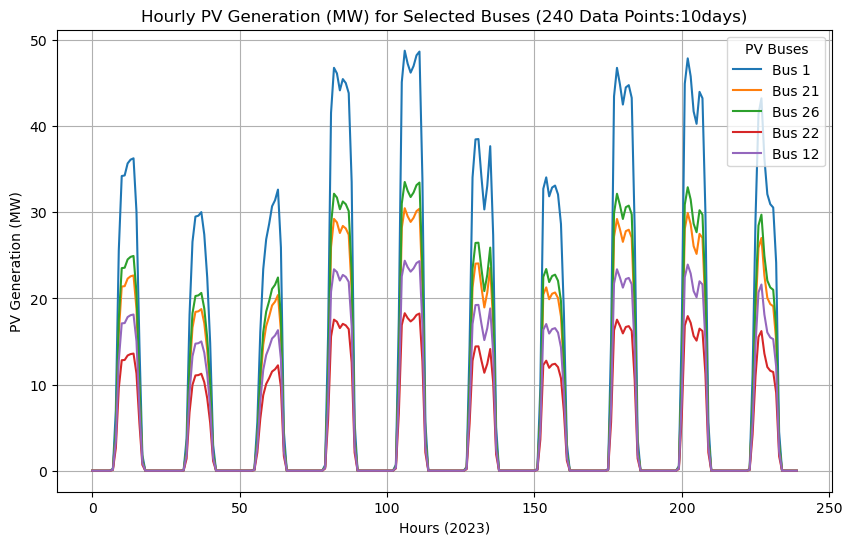

In [43]:
# Plotting the first 240 data points for each bus
plt.figure(figsize=(10, 6))
for i, bus in enumerate(pv_buses):
    plt.plot(pv_generation_data.index[:240], pv_generation_data.iloc[:240, i], label=f'Bus {bus}')

# Setting labels and title
plt.xlabel('Hours (2023)')
plt.ylabel('PV Generation (MW)')
plt.title('Hourly PV Generation (MW) for Selected Buses (240 Data Points:10days)')
plt.legend(title="PV Buses")
plt.grid(True)
plt.show()

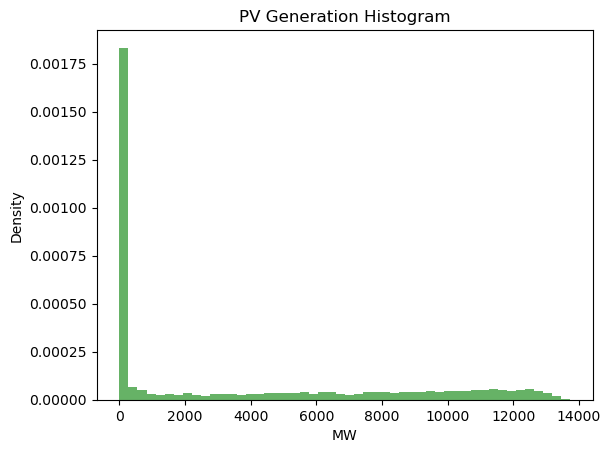

In [10]:
# Plot histogram of the data to visually inspect distribution
plt.hist(pv_generation, bins=50, density=True, alpha=0.6, color='g')
plt.title("PV Generation Histogram")
plt.xlabel("MW")
plt.ylabel("Density")
plt.show()

## Perform optimal power flow (OPF) analysis

In [11]:
pp.runopp(net)
print("OPF Results:")
print(net.res_bus)
print(net.res_line)

OPF Results:
       vm_pu  va_degree       p_mw     q_mvar     lam_p         lam_q
0   1.000000   0.000000 -39.448392  19.949940  3.577936 -4.143238e-03
1   1.004029  -0.836057 -31.402858  -5.477128  3.608594 -2.971973e-08
2   0.999105  -2.239730   2.400000   1.200000  3.671995  4.266441e-03
3   0.999526  -2.655931   7.600000   1.600000  3.689274  5.221961e-03
4   0.995485  -2.371100   0.000000  -0.188288  3.660976  1.874167e-02
5   0.995131  -2.952487   0.000000   0.000000  3.694853  2.294117e-02
6   0.985949  -3.252072  22.800000  10.900000  3.715213  3.591101e-02
7   0.983916  -3.354916  30.000000  30.000000  6.855822  3.079593e+00
8   1.012731  -3.826598   0.000000   0.000000  3.760950  4.003894e-02
9   1.022042  -4.272397   5.800000   2.000000  3.794853  4.798086e-02
10  1.012731  -3.826598   0.000000   0.000000  3.760950  4.003829e-02
11  1.044342  -4.355654  11.200000   7.500000  3.756287  1.369208e-03
12  1.099003  -3.298512 -15.125197 -43.047720  3.756254  3.822850e-04
13  1.0

 ## Monte Carlo Analysis for system reliability

In [28]:
# Calculate mean and std for each PV bus from 2023 data
pv_bus_means =  pv_generation_data.mean()
pv_bus_stds =  pv_generation_data.std()

# Print the mean and standard deviation for each PV bus
print("Mean Generation for each PV bus:\n", pv_bus_means )
print("\nStandard Deviation for each PV bus:\n", pv_bus_stds)

Mean Generation for each PV bus:
 0    20.42496
1    12.76560
2    14.04216
3     7.65936
4    10.21248
dtype: float64

Standard Deviation for each PV bus:
 0    25.622111
1    16.013819
2    17.615201
3     9.608292
4    12.811055
dtype: float64


In [32]:
# Set the number of Monte Carlo simulations
num_simulations = 5000

In [42]:
# ReLoad the ERCOT 300-bus system model
net = pn.case300()
# Initialize arrays to store results
lolp_count = 0  # Count of loss of load events
unmet_demand_hours = 0  # Total hours of unmet demand

# Add static (PV) and traditional generators to each PV bus
for i, bus in enumerate(pv_buses):
    # Traditional generator (voltage-controlled gen)
    if f"Traditional_gen_{bus}" not in net.gen['name'].values:
        pp.create_gen(net, bus, p_mw=0, vm_pu=1.00, max_p_mw=50, name=f"Traditional_gen_{bus}")
    # Photovoltaic generator as a static generator (sgen)
    if f"PV_sgen_{bus}" not in net.sgen['name'].values:
        pp.create_sgen(net, bus, p_mw=pv_bus_means[i], max_p_mw=pv_bus_means[i] + pv_bus_stds[i], name=f"PV_sgen_{bus}")
        
# Run Monte Carlo simulations
for sim in range(num_simulations):
    # Sample PV generation for each bus
    pv_samples = [np.random.normal(pv_bus_means[i], pv_bus_stds[i]) for i in range(len(pv_buses))]
    
    # Assign PV generation to static generators
    for i, bus in enumerate(pv_buses):
        pv_sgen_index = net.sgen[net.sgen['bus'] == bus].index[0]
        net.sgen.at[pv_sgen_index, 'p_mw'] = pv_samples[i]
    
    # Run power flow
    pp.runpp(net)
    
    # Check for unmet demand
    total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
    total_load = net.load['p_mw'].sum()
    
    if total_generation < total_load:
        lolp_count += 1
        unmet_demand_hours += 1

# Calculate reliability metrics
lolp = lolp_count / num_simulations
lole = lolp * num_simulations

print(f"Loss of Load Probability (LOLP): {lolp}")
print(f"Loss of Load Expectation (LOLE) over {num_simulations} hours: {lole}")

Loss of Load Probability (LOLP): 0.1382
Loss of Load Expectation (LOLE) over 5000 hours: 691.0
